# Optimización código de construcción y entrenamiento de la CSNN con arquitectura PilotNet

In [15]:
# Instalación de paquetes necesarios
!pip install torch snntorch codecarbon onnx onnxruntime

[codecarbon INFO @ 08:54:37] Energy consumed for RAM : 0.008999 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 08:54:37] Energy consumed for all GPUs : 0.014895 kWh. Total GPU Power : 33.54059064793343 W
[codecarbon INFO @ 08:54:37] Energy consumed for all CPUs : 0.020008 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:54:37] 0.043902 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:54:39] Energy consumed for RAM : 0.005814 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 08:54:39] Energy consumed for all GPUs : 0.010229 kWh. Total GPU Power : 33.53778264518972 W
[codecarbon INFO @ 08:54:39] Energy consumed for all CPUs : 0.012926 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:54:39] 0.028968 kWh of electricity used since the beginning.


In [16]:
# Importar librerías
import cv2
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import snntorch as snn
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from codecarbon import EmissionsTracker
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from snntorch import surrogate
from snntorch import functional as SF
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import onnx
import onnxruntime as ort


[codecarbon INFO @ 08:54:44] Energy consumed for RAM : 0.010114 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 08:54:44] Energy consumed for all GPUs : 0.016531 kWh. Total GPU Power : 33.764499445417854 W
[codecarbon INFO @ 08:54:44] Energy consumed for all CPUs : 0.022487 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:54:44] 0.049132 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:54:44] Energy consumed for RAM : 0.011469 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 08:54:44] Energy consumed for all GPUs : 0.018475 kWh. Total GPU Power : 33.53882283345839 W
[codecarbon INFO @ 08:54:44] Energy consumed for all CPUs : 0.025497 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:54:44] 0.055441 kWh of electricity used since the beginning.


In [17]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# Habilitar la detección de anomalías
torch.autograd.set_detect_anomaly(True)

# Definir EarlyStopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif val_loss >= self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Función para cargar datos desde HDF5
def load_hdf5(file_name):
    with h5py.File(file_name, 'r') as f:
        delta_images = torch.tensor(f['delta_images'][:])
        angles = torch.tensor(f['angles'][:])
    return delta_images, angles

# Función para guardar datos en HDF5
def save_to_hdf5(delta_images, angles, file_name):
    with h5py.File(file_name, 'w') as f:
        f.create_dataset('delta_images', data=delta_images.cpu().numpy(), compression="gzip")
        f.create_dataset('angles', data=angles.cpu().numpy(), compression="gzip")

# Cargar datos de entrenamiento y validación desde HDF5
training_delta_images, training_angles = load_hdf5('/content/drive/MyDrive/UOC/TFM/Spike Encoding/training_data_pairs4.hdf5')
validation_delta_images, validation_angles = load_hdf5('/content/drive/MyDrive/UOC/TFM/Spike Encoding/validation_data_pairs4.hdf5')

# Añadir una dimensión de canal a las imágenes
training_delta_images = training_delta_images.unsqueeze(1)  # Añadir canal de entrada
validation_delta_images = validation_delta_images.unsqueeze(1)  # Añadir canal de entrada

# Guardar los datos ajustados en nuevos archivos HDF5
save_to_hdf5(training_delta_images, training_angles, 'adjusted_training_data.hdf5')
save_to_hdf5(validation_delta_images, validation_angles, 'adjusted_validation_data.hdf5')

# Copiar archivos ajustados a Google Drive
shutil.copy2('adjusted_training_data.hdf5', '/content/drive/MyDrive/UOC/TFM/Spike Encoding/adjusted_training_data.hdf5')
shutil.copy2('adjusted_validation_data.hdf5', '/content/drive/MyDrive/UOC/TFM/Spike Encoding/adjusted_validation_data.hdf5')

print(f"Total de pares de datos codificados y ajustados en entrenamiento: {training_delta_images.shape[0]}")
print(f"Total de pares de datos codificados y ajustados en validación: {validation_delta_images.shape[0]}")



[codecarbon INFO @ 09:59:39] Energy consumed for RAM : 0.026520 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 09:59:39] Energy consumed for all GPUs : 0.045314 kWh. Total GPU Power : 31.576121826784195 W
[codecarbon INFO @ 09:59:39] Energy consumed for all CPUs : 0.058962 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:59:39] 0.130796 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:59:44] Energy consumed for RAM : 0.030821 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 09:59:44] Energy consumed for all GPUs : 0.051614 kWh. Total GPU Power : 31.806870856873463 W
[codecarbon INFO @ 09:59:44] Energy consumed for all CPUs : 0.068524 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:59:44] 0.150958 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:59:44] Energy consumed for RAM : 0.032175 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 09:59:44] Energy consumed for all GPUs : 0.053558 kWh. Total GPU Power : 31.594521543867646

Total de pares de datos codificados y ajustados en entrenamiento: 22051
Total de pares de datos codificados y ajustados en validación: 5513


[codecarbon WARNING @ 10:00:02] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 10:00:02] [setup] RAM Tracking...
[codecarbon INFO @ 10:00:02] [setup] GPU Tracking...
[codecarbon INFO @ 10:00:02] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 10:00:02] [setup] CPU Tracking...
[codecarbon WARNING @ 10:00:02] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 10:00:03] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 10:00:03] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 10:00:03] >>> Tracker's metadata:
[codecarbon INFO @ 10:00:03]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 10:00:03]   Python version: 3.10.12
[codecarbon INFO @ 10:00:03]   CodeCarbon version: 2.4.2
[codecarbon INFO @ 10:00:03]   Available RAM : 50.994 GB
[codecarbon INFO @ 10:00:03]   CPU count: 8
[codecarbon INFO

Salida del modelo (primer lote, primera época): tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.,

[codecarbon INFO @ 10:00:07] Energy consumed for RAM : 0.029865 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:00:07] Energy consumed for all GPUs : 0.050249 kWh. Total GPU Power : 32.73952249994741 W
[codecarbon INFO @ 10:00:07] Energy consumed for all CPUs : 0.066398 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:00:07] 0.146513 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:00:09] Energy consumed for RAM : 0.026679 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:00:09] Energy consumed for all GPUs : 0.045584 kWh. Total GPU Power : 33.0944523780735 W
[codecarbon INFO @ 10:00:09] Energy consumed for all CPUs : 0.059316 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:00:09] 0.131580 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:00:14] Energy consumed for RAM : 0.030980 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:00:14] Energy consumed for all GPUs : 0.051888 kWh. Total GPU Power : 34.06059054395756 W
[

Epoch [1/50], Train Loss: 0.0448, Train Accuracy: 0.0989, Valid Loss: 0.0447, Valid Accuracy: 0.1012


[codecarbon INFO @ 10:00:44] Energy consumed for RAM : 0.031139 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:00:44] Energy consumed for all GPUs : 0.052183 kWh. Total GPU Power : 35.46952577116268 W
[codecarbon INFO @ 10:00:44] Energy consumed for all CPUs : 0.069232 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:00:44] 0.152554 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:00:44] Energy consumed for RAM : 0.032494 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:00:44] Energy consumed for all GPUs : 0.054127 kWh. Total GPU Power : 35.47002381568041 W
[codecarbon INFO @ 10:00:44] Energy consumed for all CPUs : 0.072242 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:00:44] 0.158863 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:00:47] Energy consumed for RAM : 0.030104 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:00:47] Energy consumed for all GPUs : 0.050679 kWh. Total GPU Power : 35.49276648803412 W


Epoch [2/50], Train Loss: 0.0447, Train Accuracy: 0.1018, Valid Loss: 0.0447, Valid Accuracy: 0.1012


[codecarbon INFO @ 10:01:22] Energy consumed for RAM : 0.030263 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:01:22] Energy consumed for all GPUs : 0.050989 kWh. Total GPU Power : 35.848161235802564 W
[codecarbon INFO @ 10:01:22] Energy consumed for all CPUs : 0.067284 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:01:22] 0.148536 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:01:24] Energy consumed for RAM : 0.027078 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:01:24] Energy consumed for all GPUs : 0.046324 kWh. Total GPU Power : 35.85393375798178 W
[codecarbon INFO @ 10:01:24] Energy consumed for all CPUs : 0.060201 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:01:24] 0.133603 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:01:29] Energy consumed for RAM : 0.031378 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:01:29] Energy consumed for all GPUs : 0.052630 kWh. Total GPU Power : 36.13192248783829 W

Epoch [3/50], Train Loss: 0.0447, Train Accuracy: 0.0988, Valid Loss: 0.0447, Valid Accuracy: 0.1012


[codecarbon INFO @ 10:01:59] Energy consumed for RAM : 0.031537 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:01:59] Energy consumed for all GPUs : 0.052930 kWh. Total GPU Power : 36.14035258252713 W
[codecarbon INFO @ 10:01:59] Energy consumed for all CPUs : 0.070117 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:01:59] 0.154584 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:01:59] Energy consumed for RAM : 0.032892 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:01:59] Energy consumed for all GPUs : 0.054874 kWh. Total GPU Power : 36.14658562666056 W
[codecarbon INFO @ 10:01:59] Energy consumed for all CPUs : 0.073127 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:01:59] 0.160893 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:02:02] Energy consumed for RAM : 0.030502 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:02:02] Energy consumed for all GPUs : 0.051427 kWh. Total GPU Power : 36.186601267677034 W

Epoch [4/50], Train Loss: 0.0447, Train Accuracy: 0.1010, Valid Loss: 0.0446, Valid Accuracy: 0.1012


[codecarbon INFO @ 10:02:39] Energy consumed for RAM : 0.027476 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:02:39] Energy consumed for all GPUs : 0.047079 kWh. Total GPU Power : 36.56420271245607 W
[codecarbon INFO @ 10:02:39] Energy consumed for all CPUs : 0.061087 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:02:39] 0.135641 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:02:44] Energy consumed for RAM : 0.031776 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:02:44] Energy consumed for all GPUs : 0.053385 kWh. Total GPU Power : 36.56308089116653 W
[codecarbon INFO @ 10:02:44] Energy consumed for all CPUs : 0.070648 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:02:44] 0.155810 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:02:44] Energy consumed for RAM : 0.033131 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:02:44] Energy consumed for all GPUs : 0.055330 kWh. Total GPU Power : 36.563445983516544 W

Epoch [5/50], Train Loss: 0.0447, Train Accuracy: 0.1000, Valid Loss: 0.0447, Valid Accuracy: 0.1012


[codecarbon INFO @ 10:03:17] Energy consumed for RAM : 0.030900 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:03:17] Energy consumed for all GPUs : 0.052189 kWh. Total GPU Power : 37.045313446584764 W
[codecarbon INFO @ 10:03:17] Energy consumed for all CPUs : 0.068700 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:03:17] 0.151789 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:03:17] Energy consumed for RAM : 0.029465 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:03:17] Energy consumed for all GPUs : 0.050097 kWh. Total GPU Power : 37.04655347261277 W
[codecarbon INFO @ 10:03:17] Energy consumed for all CPUs : 0.065513 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:03:17] 0.145075 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:03:19] Energy consumed for RAM : 0.001035 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:03:19] Energy consumed for all GPUs : 0.001952 kWh. Total GPU Power : 37.04398592379673 W

Epoch [6/50], Train Loss: 0.0447, Train Accuracy: 0.1014, Valid Loss: 0.0446, Valid Accuracy: 0.1012


[codecarbon INFO @ 10:03:59] Energy consumed for RAM : 0.032174 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:03:59] Energy consumed for all GPUs : 0.054154 kWh. Total GPU Power : 37.1689959078985 W
[codecarbon INFO @ 10:03:59] Energy consumed for all CPUs : 0.071534 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:03:59] 0.157862 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:03:59] Energy consumed for RAM : 0.033529 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:03:59] Energy consumed for all GPUs : 0.056098 kWh. Total GPU Power : 37.16579140883146 W
[codecarbon INFO @ 10:03:59] Energy consumed for all CPUs : 0.074543 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:03:59] 0.164171 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:04:02] Energy consumed for RAM : 0.031139 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:04:02] Energy consumed for all GPUs : 0.052651 kWh. Total GPU Power : 37.45008686539788 W
[

Epoch [7/50], Train Loss: 0.0447, Train Accuracy: 0.1005, Valid Loss: 0.0447, Valid Accuracy: 0.1012


[codecarbon INFO @ 10:04:34] Energy consumed for RAM : 0.001433 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:04:34] Energy consumed for all GPUs : 0.002726 kWh. Total GPU Power : 37.228535251854424 W
[codecarbon INFO @ 10:04:34] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:04:34] 0.007346 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:04:37] Energy consumed for RAM : 0.031298 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:04:37] Energy consumed for all GPUs : 0.052976 kWh. Total GPU Power : 37.16857739264726 W
[codecarbon INFO @ 10:04:37] Energy consumed for all CPUs : 0.069585 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:04:37] 0.153860 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:04:39] Energy consumed for RAM : 0.028113 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:04:39] Energy consumed for all GPUs : 0.048311 kWh. Total GPU Power : 37.16252527517093 W

Epoch [8/50], Train Loss: 0.0446, Train Accuracy: 0.1031, Valid Loss: 0.0446, Valid Accuracy: 0.1012


[codecarbon INFO @ 10:05:14] Energy consumed for RAM : 0.032573 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:05:14] Energy consumed for all GPUs : 0.054927 kWh. Total GPU Power : 36.83865129689288 W
[codecarbon INFO @ 10:05:14] Energy consumed for all CPUs : 0.072419 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:05:14] 0.159918 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:05:14] Energy consumed for RAM : 0.033927 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:05:14] Energy consumed for all GPUs : 0.056871 kWh. Total GPU Power : 36.830506521176574 W
[codecarbon INFO @ 10:05:14] Energy consumed for all CPUs : 0.075429 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:05:14] 0.166227 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:05:17] Energy consumed for RAM : 0.031537 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:05:17] Energy consumed for all GPUs : 0.053424 kWh. Total GPU Power : 36.81730725908275 W

Epoch [9/50], Train Loss: 0.0446, Train Accuracy: 0.1011, Valid Loss: 0.0446, Valid Accuracy: 0.1012


[codecarbon INFO @ 10:05:52] Energy consumed for RAM : 0.031696 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:05:52] Energy consumed for all GPUs : 0.053747 kWh. Total GPU Power : 37.289280599717934 W
[codecarbon INFO @ 10:05:52] Energy consumed for all CPUs : 0.070471 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:05:52] 0.155914 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:05:54] Energy consumed for RAM : 0.028511 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:05:54] Energy consumed for all GPUs : 0.049083 kWh. Total GPU Power : 37.31183226093528 W
[codecarbon INFO @ 10:05:54] Energy consumed for all CPUs : 0.063388 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:05:54] 0.140982 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:05:59] Energy consumed for RAM : 0.032812 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:05:59] Energy consumed for all GPUs : 0.055389 kWh. Total GPU Power : 37.06926002351299 W

Epoch [10/50], Train Loss: 0.0446, Train Accuracy: 0.0999, Valid Loss: 0.0447, Valid Accuracy: 0.1012


[codecarbon INFO @ 10:06:29] Energy consumed for RAM : 0.032971 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:06:29] Energy consumed for all GPUs : 0.055699 kWh. Total GPU Power : 37.27247997387299 W
[codecarbon INFO @ 10:06:29] Energy consumed for all CPUs : 0.073304 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:06:29] 0.161974 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:06:29] Energy consumed for RAM : 0.034326 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:06:29] Energy consumed for all GPUs : 0.057643 kWh. Total GPU Power : 37.26898179963473 W
[codecarbon INFO @ 10:06:29] Energy consumed for all CPUs : 0.076314 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:06:29] 0.168283 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:06:32] Energy consumed for RAM : 0.031935 kWh. RAM Power : 19.1226167678833 W
[codecarbon INFO @ 10:06:32] Energy consumed for all GPUs : 0.054196 kWh. Total GPU Power : 37.2502045966664 W
[

Epoch [11/50], Train Loss: 0.0446, Train Accuracy: 0.0999, Valid Loss: 0.0446, Valid Accuracy: 0.0954
Early stopping en la época 11
Emisiones estimadas de CO2: 0.01 kg
Energía consumida: 0.01 kWh
Mejor pérdida de validación: 0.0446


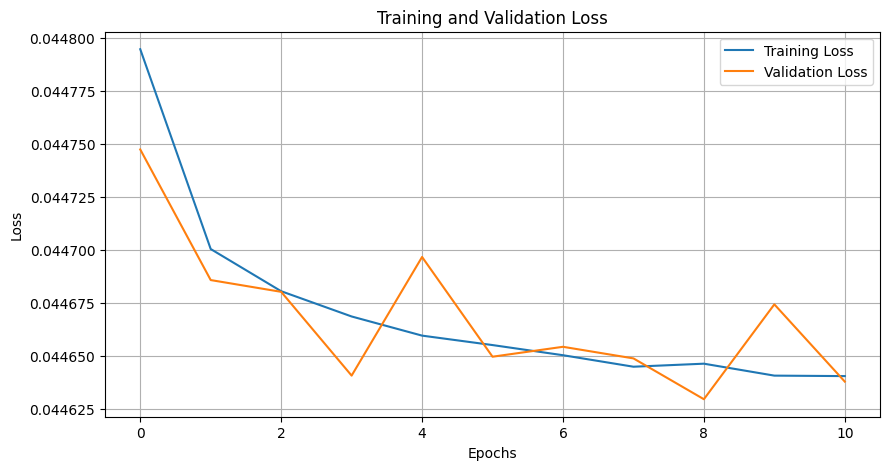

In [30]:
# Definir la arquitectura CSNN basada en PilotNet
class CSNNPilotNet(nn.Module):
    def __init__(self):
        super(CSNNPilotNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 24, kernel_size=5, stride=2)  # Cambiar el número de canales a 1
        self.conv2 = nn.Conv2d(24, 36, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(36, 48, kernel_size=5, stride=2)
        self.conv4 = nn.Conv2d(48, 64, kernel_size=3)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3)

        beta = 0.9
        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        self.lif2 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        self.lif3 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        self.lif4 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        self.lif5 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())

        self.fc1 = nn.Linear(64*1*18, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)
        self.fc4 = nn.Linear(10, 21)

    def forward(self, x, mem1, mem2, mem3, mem4, mem5):
        x = self.conv1(x)
        x, mem1 = self.lif1(x, mem1)
        x = self.conv2(x)
        x, mem2 = self.lif2(x, mem2)
        x = self.conv3(x)
        x, mem3 = self.lif3(x, mem3)
        x = self.conv4(x)
        x, mem4 = self.lif4(x, mem4)
        x = self.conv5(x)
        x, mem5 = self.lif5(x, mem5)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x, mem1, mem2, mem3, mem4, mem5

# Inicializar el modelo
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CSNNPilotNet().to(device)

# Inicializar las capas ocultas de la red
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)

# Crear DataLoaders para entrenamiento y validación
batch_size = 16
train_dataset = TensorDataset(training_delta_images, training_angles)
valid_dataset = TensorDataset(validation_delta_images, validation_angles)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Definir el optimizador y la función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Función para calcular la precisión
def calculate_accuracy(output, target):
    _, predicted = torch.max(output, 1)
    _, target_max = torch.max(target, 1)
    correct = (predicted == target_max).sum().item()
    return correct / len(target)

# Ciclo de entrenamiento
num_epochs = 50
train_losses = []
valid_losses = []

# Inicializar EarlyStopping
early_stopping = EarlyStopping(patience=10, min_delta=0.001)

# Iniciar el tracker de CodeCarbon
tracker = EmissionsTracker()
tracker.start()

best_valid_loss = float('inf')
best_model_wts = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train = 0

    for i, (delta_images, angles) in enumerate(train_loader):
        # Asegurarse de que las entradas no sean tuplas
        if isinstance(delta_images, tuple):
            delta_images = delta_images[0]
        if isinstance(angles, tuple):
            angles = angles[0]

        delta_images, angles = delta_images.to(device), angles.to(device)

        # Convertir angles a Float
        angles = angles.float()

        optimizer.zero_grad()

        # Inicializar memorias
        mem1 = model.lif1.init_leaky()
        mem2 = model.lif2.init_leaky()
        mem3 = model.lif3.init_leaky()
        mem4 = model.lif4.init_leaky()
        mem5 = model.lif5.init_leaky()

        outputs, mem1, mem2, mem3, mem4, mem5 = model(delta_images, mem1, mem2, mem3, mem4, mem5)
        loss = criterion(outputs, angles)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_correct += calculate_accuracy(outputs, angles) * len(delta_images)
        total_train += len(delta_images)

        # Imprimir la salida del modelo para el primer lote
        if epoch == 0 and i == 0:
            print(f"Salida del modelo (primer lote, primera época): {outputs}")

    train_losses.append(train_loss / len(train_loader))
    train_accuracy = train_correct / total_train

    # Validación
    model.eval()
    valid_loss = 0.0
    valid_correct = 0
    total_valid = 0

    with torch.no_grad():
        for delta_images, angles in valid_loader:
            # Asegurarse de que las entradas no sean tuplas
            if isinstance(delta_images, tuple):
                delta_images = delta_images[0]
            if isinstance(angles, tuple):
                angles = angles[0]

            delta_images, angles = delta_images.to(device), angles.to(device)

            # Convertir angles a Float
            angles = angles.float()

            # Inicializar memorias
            mem1 = model.lif1.init_leaky()
            mem2 = model.lif2.init_leaky()
            mem3 = model.lif3.init_leaky()
            mem4 = model.lif4.init_leaky()
            mem5 = model.lif5.init_leaky()

            outputs, mem1, mem2, mem3, mem4, mem5 = model(delta_images, mem1, mem2, mem3, mem4, mem5)
            loss = criterion(outputs, angles)
            valid_loss += loss.item()

            valid_correct += calculate_accuracy(outputs, angles) * len(delta_images)
            total_valid += len(delta_images)

    valid_losses.append(valid_loss / len(valid_loader))
    valid_accuracy = valid_correct / total_valid

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, Valid Loss: {valid_loss/len(valid_loader):.4f}, Valid Accuracy: {valid_accuracy:.4f}")

    # Guardar el mejor modelo
    if valid_loss / len(valid_loader) < best_valid_loss:
        best_valid_loss = valid_loss / len(valid_loader)
        best_model_wts = model.state_dict()

    # Comprobar para el early stopping
    early_stopping(valid_loss / len(valid_loader))
    if early_stopping.early_stop:
        print(f"Early stopping en la época {epoch+1}")
        break

# Guardar el mejor modelo encontrado
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), '/content/drive/MyDrive/UOC/TFM/Spike Encoding/best_model.pth')

# Detener el tracker y mostrar el reporte
emissions = tracker.stop()
total_emissions = tracker.final_emissions
total_energy = tracker._total_energy.kWh

print(f"Emisiones estimadas de CO2: {total_emissions:.2f} kg")
print(f"Energía consumida: {total_energy:.2f} kWh")

print(f"Mejor pérdida de validación: {best_valid_loss:.4f}")

# Graficar las pérdidas de entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
